# **Part-1: Moving Average (MA) Model**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas.plotting import register_matplotlib_converters
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime, timedelta
#register_matplotlib_converters()

# Generate Data

## **Model Equation**
### **y_hat(t) = 50 + 0.4*error(t-1) + 0.3*error(t-2)**
### error(t) ~ N(0, 1)


In [60]:
errors = np.random.normal(0, 1, 400)

In [61]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [62]:
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [63]:
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))

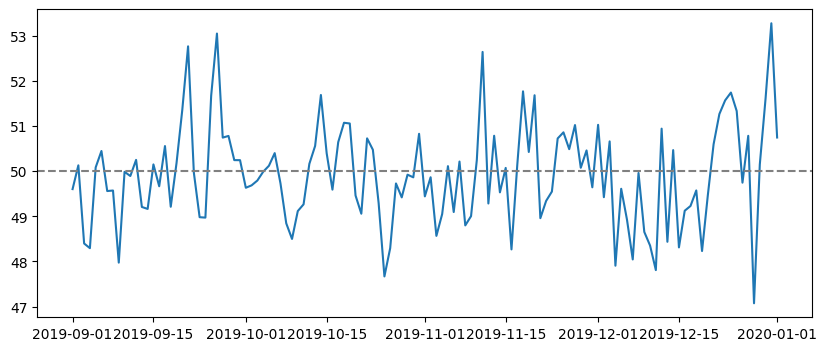

In [64]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

In [65]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

In [98]:
#series

In [96]:
# series[:-2]

In [97]:
# series[2:]

#ACF

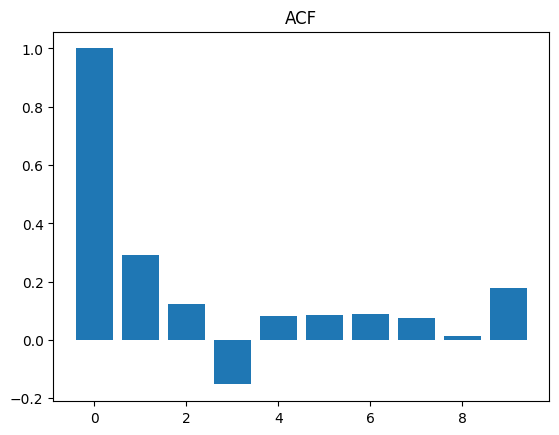

In [69]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.title('ACF')
plt.show()

# PACF

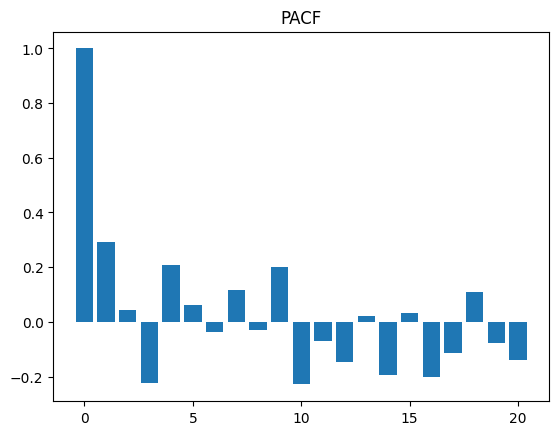

In [70]:
pacf_vals = pacf(series)
num_lags = 21
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title('PACF')
plt.show()

# Get training and testing sets

In [71]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

# Fit Model

In [72]:
#create the model
model = ARIMA(train_data, order=(0,0,2))

In [73]:
#fit the model
model_fit = model.fit()

In [74]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -175.523
Date:                Sat, 24 Jun 2023   AIC                            359.046
Time:                        06:59:53   BIC                            370.229
Sample:                    09-01-2019   HQIC                           363.588
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8978      0.158    316.780      0.000      49.589      50.207
ma.L1          0.3204      0.086      3.729      0.000       0.152       0.489
ma.L2          0.2302      0.089      2.576      0.0

# Predicted Model

## **y_hat(t) = 50 + 0.32*error(t-1) + 0.28*error(t-2)**

In [75]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [76]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [77]:
residuals = test_data - predictions

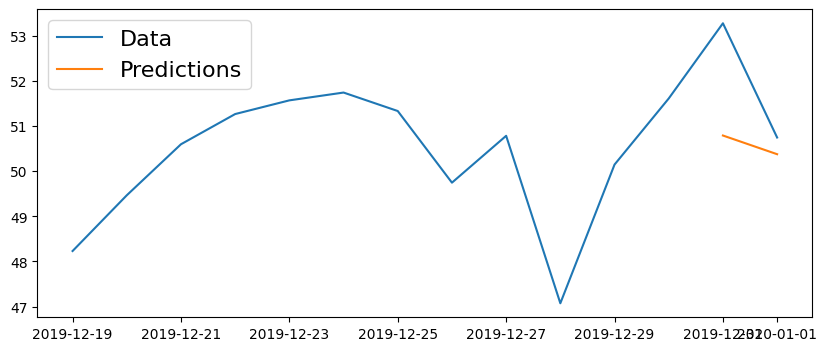

In [78]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.show()

In [79]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.027


In [80]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.778121991125167


# **Part-2: Model Selection**

# Select an **AR model** based on AIC and BIC.

In [36]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d') #  convert time stamp which is in string format to date-time object

In [3]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [23]:
#get data
series = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = series.asfreq(pd.infer_freq(series.index))

In [24]:
series

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [25]:
# Original series contains data from 1986
# Lets consider data from 2004 onwards for our analysis
series = series.loc[datetime(2004,1,1):]

## Plot and check a clear downward trend, so not stationary

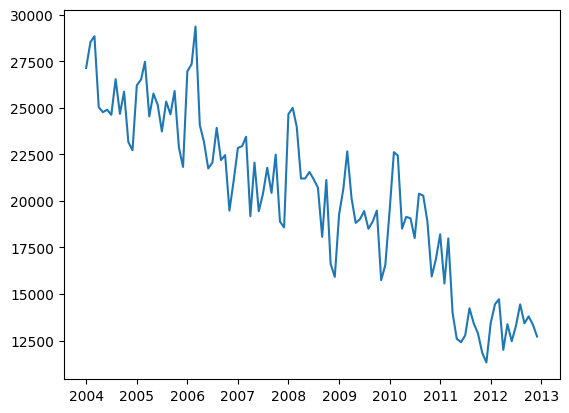

In [26]:
plt.plot(series)
plt.show()

## Perform ADF test for check stationarity

In [27]:
#check stationarity
perform_adf_test(series)

ADF Statistic: -0.383338
p-value: 0.912844


## p-value is larger than 0.05 (level of significance), we are not able to reject the Null Hypothesis (it assumes that the time series is Not Stationary).
## This high p-value suggests that the time series is not stationary.

## Stationarize with first difference

In [28]:
series = series.diff().diff().dropna() # Remove te first value with is a NaN

## Plot again

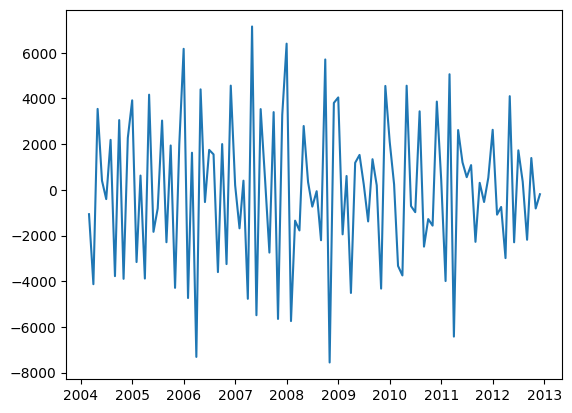

In [29]:
plt.plot(series)
plt.show()

## Again perform ADF test for check stationarity

In [30]:
#check stationarity
perform_adf_test(series)

ADF Statistic: -7.162321
p-value: 0.000000


Low p-value, we reject the Null hypothesis in favour of the alternative (it assumes that the time series is Stationary)

## Plot the PACF to find the AR components

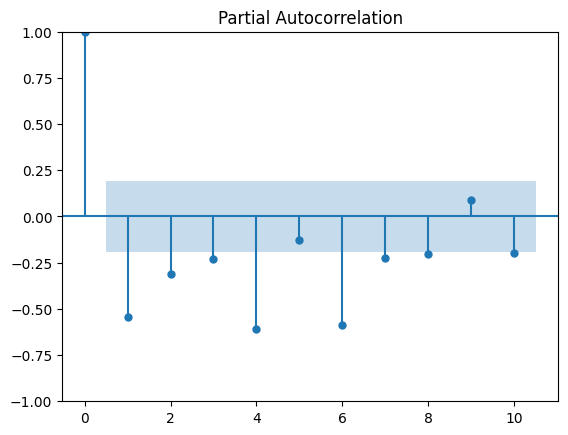

In [31]:
plot_pacf(series, lags=10)
plt.show()

### The spikes at lags 1, 4, 6 shows the presence of strong autoregressive components.

### Spike at lag 10 is also marginally overshooting the error-band (95% confidence interval).


# Either AR(1), AR(4), AR(6), or AR(10)

### **class statsmodels.tsa.arima.model.ARIMA**
**order** > tuple, optional >>  
The (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.

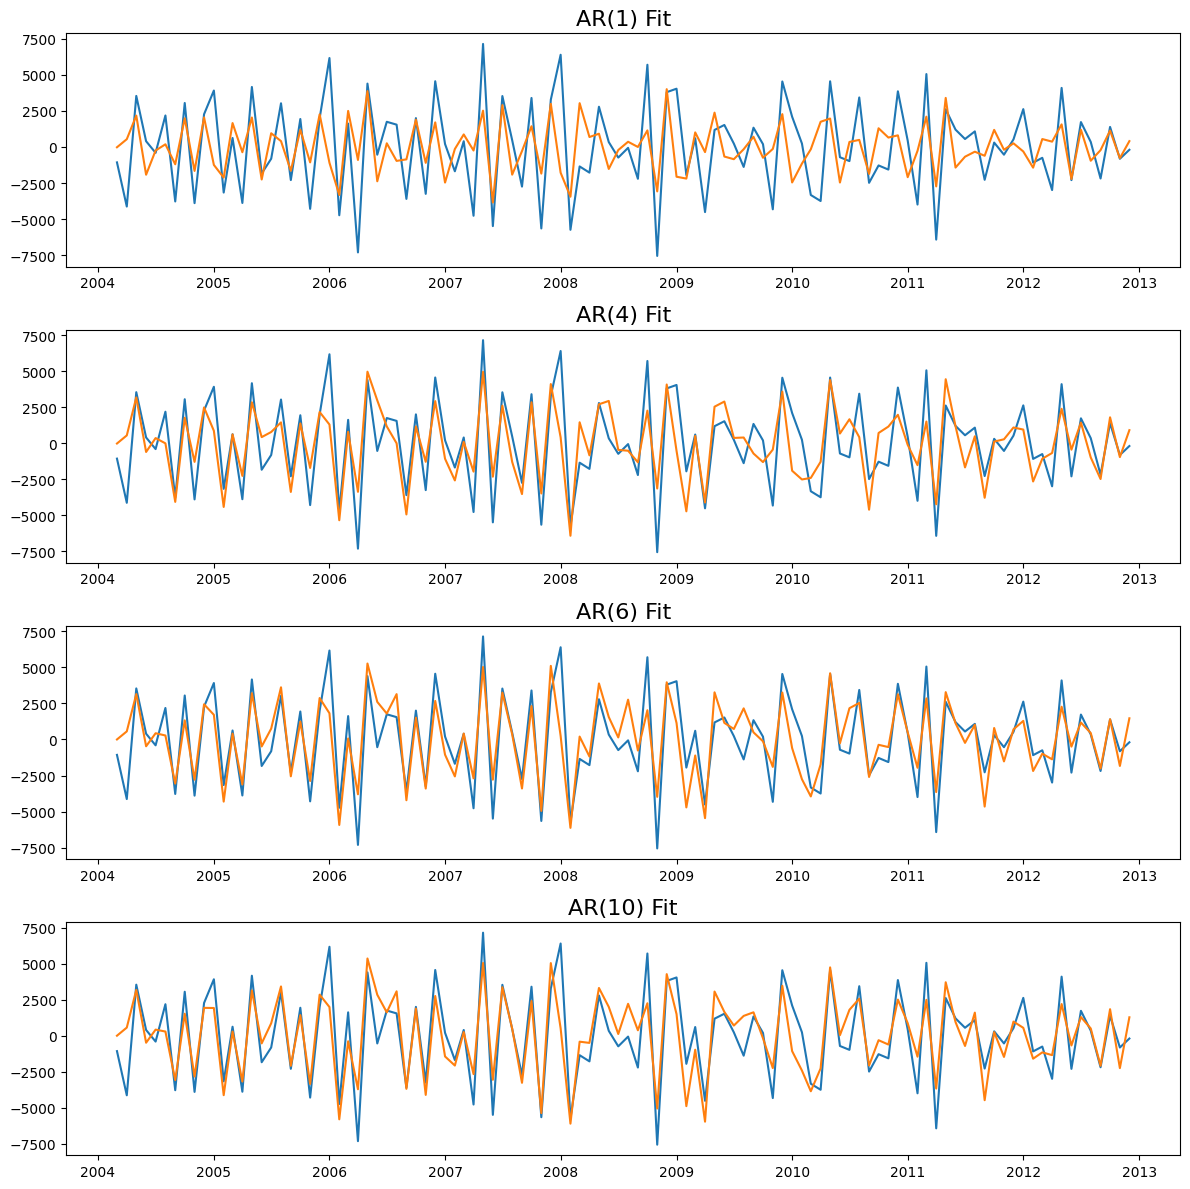

In [52]:
plt.figure(figsize=(12,12))

ar_orders = [1, 4, 6, 10]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):

    #create AR(p) model
    ar_model = ARIMA(series, order=(ar_order,0, 0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit

    plt.subplot(4,1,idx+1)
    plt.plot(series)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

# Each model has:

### a log likelihood (l)
### a number of parameters (k)
### a number of samples used for fitting (n)

## AIC = 2k - 2l
### Lower AIC via higher log likelihood or less parameters

## BIC = ln(n)k- 2l
### Lower BIC via higher log likelihood or less parameters or less samples used in fitting

### Based on AIC criteria, pick AR(6)

In [45]:
#AIC comparison
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 1980.860621744531
AIC for AR(4): 1927.609985266023
AIC for AR(6): 1899.6497442124326
AIC for AR(10): 1902.3765450084227


### Based on BIC criteria, pick AR(6)

In [46]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 1988.8509390268673
BIC for AR(4): 1943.5906198306952
BIC for AR(6): 1920.9572569653292
BIC for AR(10): 1934.3378141377675


In [53]:
#fitted_model_dict